# Project enda : Example A

In this example notebook, we will show how to read and manipulate contracts data on a small sample.
Then we will show how to align it with consumption, weather and TSO forecast data in order to train it and make a load forecast.

To start, you will need a python 3 installation (use a virtual environment), and to install some packages :

```bash
# create virtualenv, can use for instance {path_to_python3.9} instead of just "python3"
python3 -m venv {path-to-venv}    
source {path-to-venv}/bin/activate
which python  # check python path
python --version  # check python version
pip install --upgrade pip  # upgrade pip, the package manager
pip install pandas enda jupyter
pip install numexpr bottleneck  # optional, pandas speed boost
which jupyter  # check that the jupyter program you are using is the one in this venv
jupyter notebook  # lauch jupyter
```

Then you can download the notebook (`ExampleA.ipynb`) and the dataset (`example_a.zip`) to your local machine. Open `ExampleA.ipynb` with jupyter and follow the tutorial there instead of the pdf/html. The dataset is a micro-example of the data we typically deal with. 

We here pretend **we are exactly on '2020-09-20'** and want to predict our SLP (synthetic load profiles) customers load for the next 3 days, from '2020-09-21' to '2020-09-23' at a 15 min time-step. The desired time-zone is 'Europe/Berlin'. This load may depend on several factors such as the number of customer or the weather. In this example, we have only 3 days of training data, from '2020-09-16' to '2020-09-19'. 

Data from '2020-09-20' is not available because we do not have the most recent measured consumption data : there is a time-gap between the latest time for which we have an actual measure and the next time we want to predict. In a more realistic example, this gap may be a few days or weeks.   


The files are :
- `contracts.csv` : contains a list of 7 electricity customer contracts with different characteristics. 
- `historic_load_measured.csv` : the past load for 2 groups of customers : `smart_metered` and `slp`, from '2020-09-16' to '2020-09-19'.
- `weather_and_tso_forecasts.csv` : 2 external forecasts, the temperature and the total load on our TSO's grid, available in the past and in the future : from '2020-09-16' to '2020-09-23'. 

You can now follow this tutorial step by step. It is divided in 3 parts:
1. Deal with contracts data
2. Make a really basic prediction
3. Try it yourself


In [1]:
import os
import pandas as pd
import enda

In [2]:
# replace with the folder path where you put example_a
DIR = '/Users/emmanuel.charon/Documents/CodeProjects/enercoop/enda/data/example_a'

## 1. Deal with contracts data

In [3]:
contracts = enda.Contracts.read_contracts_from_file(os.path.join(DIR, "contracts.csv"))

In [4]:
contracts
# When date_end_exclusive = NaT, this means the contract is still active today and has no planned end date.
# Note that lines 1 and 2 are about the same customer with customer_id=1. They changed their subscribed power, 
#   so we counted it as a new contract (contract_id=1-a then 1-b).
# Note that some have a start date or an end date in the 'future' (after '2020-09-20').

,customer_id,contract_id,date_start,date_end_exclusive,sub_contract_end_reason,subscribed_power_kva,smart_metered,profile,customer_type,specific_price,estimated_annual_consumption_kwh,tension
0,1,1-a,2020-09-16,2020-09-19,changed subscribed power,6,False,RES2,residential,False,4500,BT<=36kVA RES
1,1,1-b,2020-09-19,NaT,NaN,9,False,RES2,residential,False,4500,BT<=36kVA RES
2,2,2-a,2020-09-17,2020-09-21,contract end,15,True,NaN,professionnal,True,20000,BT<=36kVA PRO
3,3,3-a,2020-09-18,NaT,NaN,3,True,NaN,residential,False,3000,BT<=36kVA RES
4,4,4-a,2020-09-19,NaT,NaN,12,False,PRO1,professionnal,False,10000,BT<=36kVA PRO
5,5,5-a,2020-09-18,2020-09-26,contract end,9,False,RES2,residential,True,5000,BT<=36kVA RES
6,6,6-a,2020-09-23,NaT,NaN,6,False,RES2,residential,True,4000,BT<=36kVA RES


In [5]:
# we are only interested in SLP customers here
contracts_slp = contracts[~contracts["smart_metered"]].copy() # drop smart-metered contracts
# add a variable to count the number of active contracts
contracts_slp["contracts_count"] = 1

In [6]:
contracts_slp

,customer_id,contract_id,date_start,date_end_exclusive,sub_contract_end_reason,subscribed_power_kva,smart_metered,profile,customer_type,specific_price,estimated_annual_consumption_kwh,tension,contracts_count
0,1,1-a,2020-09-16,2020-09-19,changed subscribed power,6,False,RES2,residential,False,4500,BT<=36kVA RES,1
1,1,1-b,2020-09-19,NaT,NaN,9,False,RES2,residential,False,4500,BT<=36kVA RES,1
4,4,4-a,2020-09-19,NaT,NaN,12,False,PRO1,professionnal,False,10000,BT<=36kVA PRO,1
5,5,5-a,2020-09-18,2020-09-26,contract end,9,False,RES2,residential,True,5000,BT<=36kVA RES,1
6,6,6-a,2020-09-23,NaT,NaN,6,False,RES2,residential,True,4000,BT<=36kVA RES,1


In [7]:
# count the running total of ["contracts_count", "subscribed_power_kva", "estimated_annual_consumption_kwh"]  each day
portfolio_slp_by_day = enda.Contracts.compute_portfolio_by_day(
    contracts_slp, 
    columns_to_sum = ["contracts_count", "subscribed_power_kva", "estimated_annual_consumption_kwh"],
    date_start_col="date_start",
    date_end_exclusive_col="date_end_exclusive"
)

In [8]:
# note that portfolio_by_day can have dates in the future (after 2020-09-20) if some contracts have a future date_end
portfolio_slp_by_day

,contracts_count,subscribed_power_kva,estimated_annual_consumption_kwh
date,,,
2020-09-16,1.0,6.0,4500.0
2020-09-17,1.0,6.0,4500.0
2020-09-18,2.0,15.0,9500.0
2020-09-19,3.0,30.0,19500.0
2020-09-20,3.0,30.0,19500.0
2020-09-21,3.0,30.0,19500.0
2020-09-22,3.0,30.0,19500.0
2020-09-23,4.0,36.0,23500.0
2020-09-24,4.0,36.0,23500.0


In [9]:
# restrict/extend the portfolio_by_day to desired dates 
portfolio_slp_by_day = enda.Contracts.get_portfolio_between_dates(
    portfolio_slp_by_day, 
    start_datetime = pd.to_datetime('2020-09-16'),
    end_datetime_exclusive = pd.to_datetime('2020-09-24')
)

In [10]:
portfolio_slp_by_day

,contracts_count,subscribed_power_kva,estimated_annual_consumption_kwh
date,,,
2020-09-16,1.0,6.0,4500.0
2020-09-17,1.0,6.0,4500.0
2020-09-18,2.0,15.0,9500.0
2020-09-19,3.0,30.0,19500.0
2020-09-20,3.0,30.0,19500.0
2020-09-21,3.0,30.0,19500.0
2020-09-22,3.0,30.0,19500.0
2020-09-23,4.0,36.0,23500.0


In [11]:
# turn the portfolio_by_day into a portfolio timeseries with our desired freq and timezone
portfolio_slp = enda.TimeSeries.interpolate_daily_to_sub_daily_data(
    portfolio_slp_by_day,
    freq='15min', 
    tz='Europe/Berlin'
)

In [12]:
portfolio_slp

,contracts_count,subscribed_power_kva,estimated_annual_consumption_kwh
time,,,
2020-09-16 00:00:00+02:00,1.0,6.0,4500.0
2020-09-16 00:15:00+02:00,1.0,6.0,4500.0
2020-09-16 00:30:00+02:00,1.0,6.0,4500.0
2020-09-16 00:45:00+02:00,1.0,6.0,4500.0
2020-09-16 01:00:00+02:00,1.0,6.0,4500.0
...,...,...,...
2020-09-23 22:45:00+02:00,4.0,36.0,23500.0
2020-09-23 23:00:00+02:00,4.0,36.0,23500.0
2020-09-23 23:15:00+02:00,4.0,36.0,23500.0


## 2. Make a really basic prediction

In [13]:
# read historical load, weather and TSO forecast data
historic_load_measured = pd.read_csv(os.path.join(DIR, "historic_load_measured.csv"))
weather_and_tso_forecasts = pd.read_csv(os.path.join(DIR, "weather_and_tso_forecasts.csv"))

In [14]:
# correctly format 'time' as a pandas.DatetimeIndex of dtype: datetime[ns, tzinfo]
for df in [historic_load_measured, weather_and_tso_forecasts]:
    df['time'] = pd.to_datetime(df['time']) 
    # for now df['time'] can be of dtype "object" because there are 2 french timezones: +60min and +120min. 
    # it is important to align time-zone to 'Europe/Berlin' to make sure the df has a pandas.DatetimeIndex
    df['time'] = enda.TimeSeries.align_timezone(df['time'], tzinfo = 'Europe/Berlin')
    df.set_index('time', inplace=True)

In [15]:
historic_load_measured

,smart_metered_kw,slp_kw
time,,
2020-09-16 00:00:00+02:00,0.0000,1.5066
2020-09-16 00:15:00+02:00,0.0000,1.4574
2020-09-16 00:30:00+02:00,0.0000,1.4082
2020-09-16 00:45:00+02:00,0.0000,1.3678
2020-09-16 01:00:00+02:00,0.0000,1.3273
...,...,...
2020-09-19 22:45:00+02:00,4.1486,9.7404
2020-09-19 23:00:00+02:00,4.0531,9.3414
2020-09-19 23:15:00+02:00,3.9842,8.8738


In [16]:
weather_and_tso_forecasts

,tso_forecast_load_mw,t_weighted
time,,
2020-09-16 00:00:00+02:00,44700.0,20.69
2020-09-16 00:15:00+02:00,43350.0,20.55
2020-09-16 00:30:00+02:00,42000.0,20.41
2020-09-16 00:45:00+02:00,40900.0,20.27
2020-09-16 01:00:00+02:00,39800.0,20.13
...,...,...
2020-09-23 22:45:00+02:00,45150.0,16.62
2020-09-23 23:00:00+02:00,46300.0,16.48
2020-09-23 23:15:00+02:00,45550.0,16.28


In [17]:
# lets create the train set with historical data

portfolio_slp_historic = portfolio_slp[portfolio_slp.index <= historic_load_measured.index.max()]

slp_historic = pd.merge(
    portfolio_slp_historic, 
    historic_load_measured[['slp_kw']], 
    how='inner', left_index=True, right_index=True
)

slp_historic = pd.merge(
    slp_historic, 
    weather_and_tso_forecasts, 
    how='inner', left_index=True, right_index=True
)

slp_historic

,contracts_count,subscribed_power_kva,estimated_annual_consumption_kwh,slp_kw,tso_forecast_load_mw,t_weighted
time,,,,,,
2020-09-16 00:00:00+02:00,1.0,6.0,4500.0,1.5066,44700.0,20.690
2020-09-16 00:15:00+02:00,1.0,6.0,4500.0,1.4574,43350.0,20.550
2020-09-16 00:30:00+02:00,1.0,6.0,4500.0,1.4082,42000.0,20.410
2020-09-16 00:45:00+02:00,1.0,6.0,4500.0,1.3678,40900.0,20.270
2020-09-16 01:00:00+02:00,1.0,6.0,4500.0,1.3273,39800.0,20.130
...,...,...,...,...,...,...
2020-09-19 22:45:00+02:00,3.0,30.0,19500.0,9.7404,42950.0,18.825
2020-09-19 23:00:00+02:00,3.0,30.0,19500.0,9.3414,44000.0,18.650
2020-09-19 23:15:00+02:00,3.0,30.0,19500.0,8.8738,43800.0,18.505


In [18]:
# lets create the input data for our forecast
portfolio_slp_forecast = portfolio_slp[portfolio_slp.index >= pd.to_datetime('2020-09-21 00:00:00+02:00')]

slp_forecast_input = pd.merge(
    portfolio_slp_forecast, 
    weather_and_tso_forecasts, 
    how='inner', left_index=True, right_index=True
)

slp_forecast_input

,contracts_count,subscribed_power_kva,estimated_annual_consumption_kwh,tso_forecast_load_mw,t_weighted
time,,,,,
2020-09-21 00:00:00+02:00,3.0,30.0,19500.0,40600.0,18.36
2020-09-21 00:15:00+02:00,3.0,30.0,19500.0,39550.0,18.18
2020-09-21 00:30:00+02:00,3.0,30.0,19500.0,38500.0,18.00
2020-09-21 00:45:00+02:00,3.0,30.0,19500.0,37450.0,17.82
2020-09-21 01:00:00+02:00,3.0,30.0,19500.0,36400.0,17.64
...,...,...,...,...,...
2020-09-23 22:45:00+02:00,4.0,36.0,23500.0,45150.0,16.62
2020-09-23 23:00:00+02:00,4.0,36.0,23500.0,46300.0,16.48
2020-09-23 23:15:00+02:00,4.0,36.0,23500.0,45550.0,16.28


In [19]:
# create minimalistic features, for the example, just the hour 
def featurize(df):
    df = df.copy(deep=True)
    df["hour"] = df.index.hour
    return df

In [20]:
slp_historic = featurize(slp_historic)
slp_forecast_input = featurize(slp_forecast_input)

In this example we will use a simple linear regression using the implementation in `sklearn`.
Enda has a wrapper that works with any sklearn estimator : `enda.ml_backends.sklearn_estimator.SklearnEstimator`. It makes it easier to deal with timeseries and pandas dataframes.
To save a trained model we will use `joblib`.

Install the requirements:
```bash
pip install scikit-learn joblib
```

In [21]:
from enda.ml_backends.sklearn_estimator import SklearnEstimator
from sklearn.linear_model import LinearRegression
import joblib

In [22]:
lin_reg = SklearnEstimator(LinearRegression())
lin_reg.train(slp_historic, target_col='slp_kw')

In [23]:
# save model to a file 
model_path = os.path.join(DIR, "lin_reg.joblib")
joblib.dump(lin_reg, model_path)  
del lin_reg

In [24]:
# load model from the file 
lin_reg = joblib.load(model_path)
prediction = lin_reg.predict(slp_forecast_input, target_col='slp_kw')
assert (prediction.index == slp_forecast_input.index).all()  # verify that the pandas.DatetimeIndex is conserved

In [25]:
prediction

,slp_kw
time,
2020-09-21 00:00:00+02:00,8.890794
2020-09-21 00:15:00+02:00,8.785566
2020-09-21 00:30:00+02:00,8.680339
2020-09-21 00:45:00+02:00,8.575111
2020-09-21 01:00:00+02:00,8.564227
...,...
2020-09-23 22:45:00+02:00,13.834379
2020-09-23 23:00:00+02:00,14.058107
2020-09-23 23:15:00+02:00,13.985939


To visualize pandas dataframes, we use `matplotlib` as backend :
```bash
pip install matplotlib
```

In [26]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='time'>

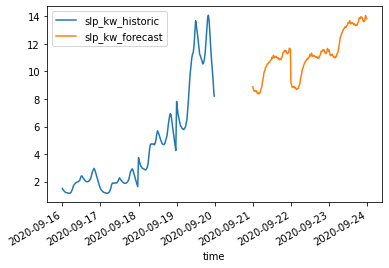

In [27]:
# plot consumption : historic and forecast
to_plot = pd.merge(
    slp_historic["slp_kw"].to_frame("slp_kw_historic"), 
    prediction.rename(columns={"slp_kw": "slp_kw_forecast"}), 
    how='outer', left_index=True, right_index=True
)
to_plot.plot()                             

<AxesSubplot:xlabel='time'>

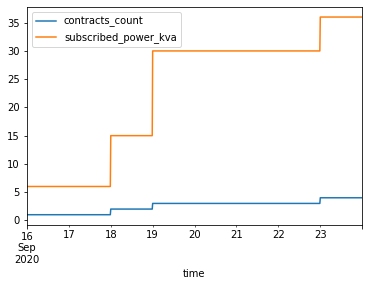

In [28]:
# plot the size of the portfolio of SLP customers over time
portfolio_slp[["contracts_count", "subscribed_power_kva"]].plot()

<AxesSubplot:xlabel='time'>

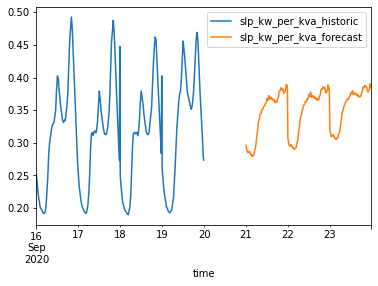

In [29]:
# plot consumption per kva: historic and forecast
to_plot = pd.merge(
    (slp_historic["slp_kw"]/slp_historic["subscribed_power_kva"]).to_frame("slp_kw_per_kva_historic"), 
    (prediction["slp_kw"]/portfolio_slp["subscribed_power_kva"]).to_frame("slp_kw_per_kva_forecast"), 
    how='outer', left_index=True, right_index=True
)
to_plot.plot()       

## 3. Try it yourself

As an exercise, you should repeat the previous analysis/prediction but this time on `smart-metered` customers.

## Conclusion

Thats all for this introduction. Go to Example B for a more complete and in-depth example.
Thanks for reading and don't hesitate to send feeback at: emmanuel.charon@enercoop.org !